In [6]:
import math 
import pandas as pd
import pandas_datareader as web 
import numpy as np 
import matplotlib.pyplot as plt 

from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

sample = 50
percentage = 0.75
stock = 'AAPL'
data_source_name = 'yahoo'
start_date = '2018-01-01'
end_date = '2022-11-30'

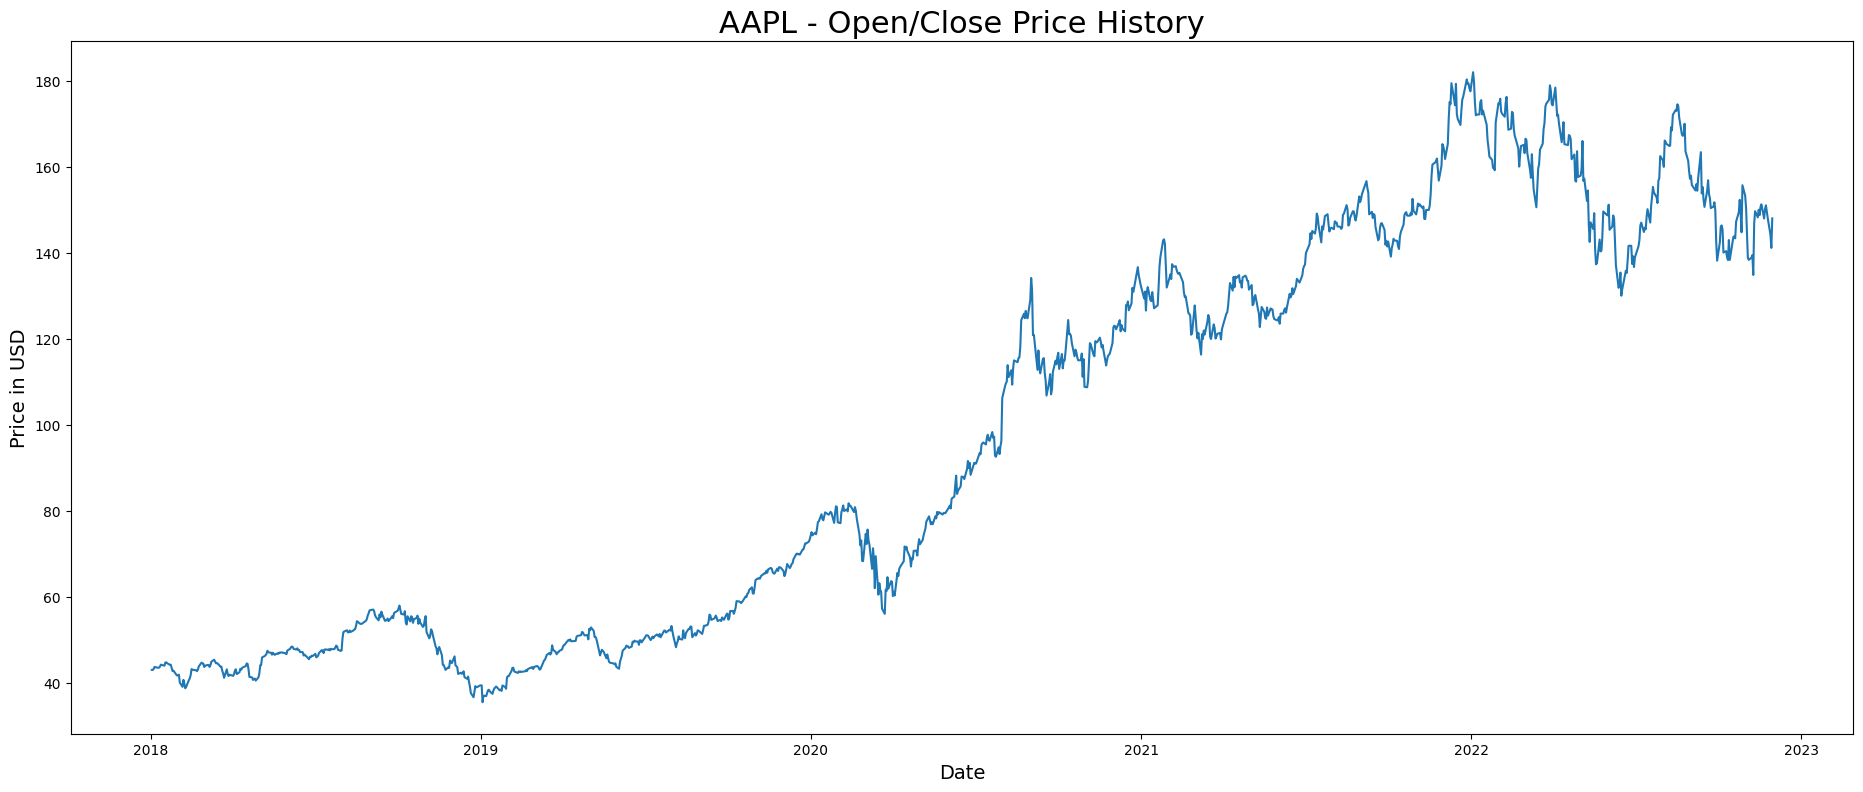

In [7]:
# Create DataFrame and show Close price chart
df = web.DataReader(stock, data_source=data_source_name, start=start_date, end=end_date)
plt.figure(figsize=(23, 9))
plt.title(stock + ' - Open/Close Price History', fontsize=22)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.show()

In [8]:
# Create a sorted DataSet based on Date and Close price
data = df.filter(['Close'])
new_dataset = data.values
data.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-25', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=1238, freq=None)

In [9]:
# Prepare train_data and valid_data
train_data_len = math.ceil(len(new_dataset) * percentage)
train_data = new_dataset[0:train_data_len, :]
valid_data = new_dataset[train_data_len:, :]
print('Train data len: ', len(train_data))
print('Valid data len: ', len(valid_data))

Train data len:  929
Valid data len:  309


In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(new_dataset)
x_train_data, y_train_data = [], []

# Train until the last <sample> values
for i in range(sample, train_data_len):
    x_train_data.append(scaled_data[i-sample:i, 0])     # first len-<sample> values
    y_train_data.append(scaled_data[i, 0])          
print('x_train_data data len: ', len(x_train_data))
print('y_train_data data len: ', len(y_train_data))

x_train_data data len:  879
y_train_data data len:  879


In [11]:
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))
x_train_data.shape[0], x_train_data.shape[1]

(879, 50)

In [12]:
# Build and train the LSTM model (Long Short Term Memory) 
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
lstm_model.fit(x_train_data, y_train_data, batch_size=1, epochs=1)

879/879 [==============================] - 14s 14ms/step - loss: 0.0017


In [14]:
# Take a sample of dataset to make stock prediction using LSTM model
test_data = scaled_data[train_data_len-sample:, :]
X_test = []
y_test = new_dataset[train_data_len:, :]
for i in range(sample, len(test_data)):
    X_test.append(test_data[i-sample:i, 0])
X_test = np.array(X_test)
X_test.shape

(309, 50)

In [15]:
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(309, 50, 1)

In [16]:
# Now get the predicted values
predicted_closed_price = lstm_model.predict(X_test)
# Apply inverse transformation
predicted_closed_price = scaler.inverse_transform(predicted_closed_price)

10/10 [==============================] - 1s 10ms/step


In [17]:
# Get the RMSE (root squared mean error)
rmse = np.sqrt( np.mean(predicted_closed_price - y_test) **2 )
rmse

2.2542156725639666

C:\Users\eugen.marin\AppData\Local\Temp\ipykernel_15920\3964072491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_closed_price


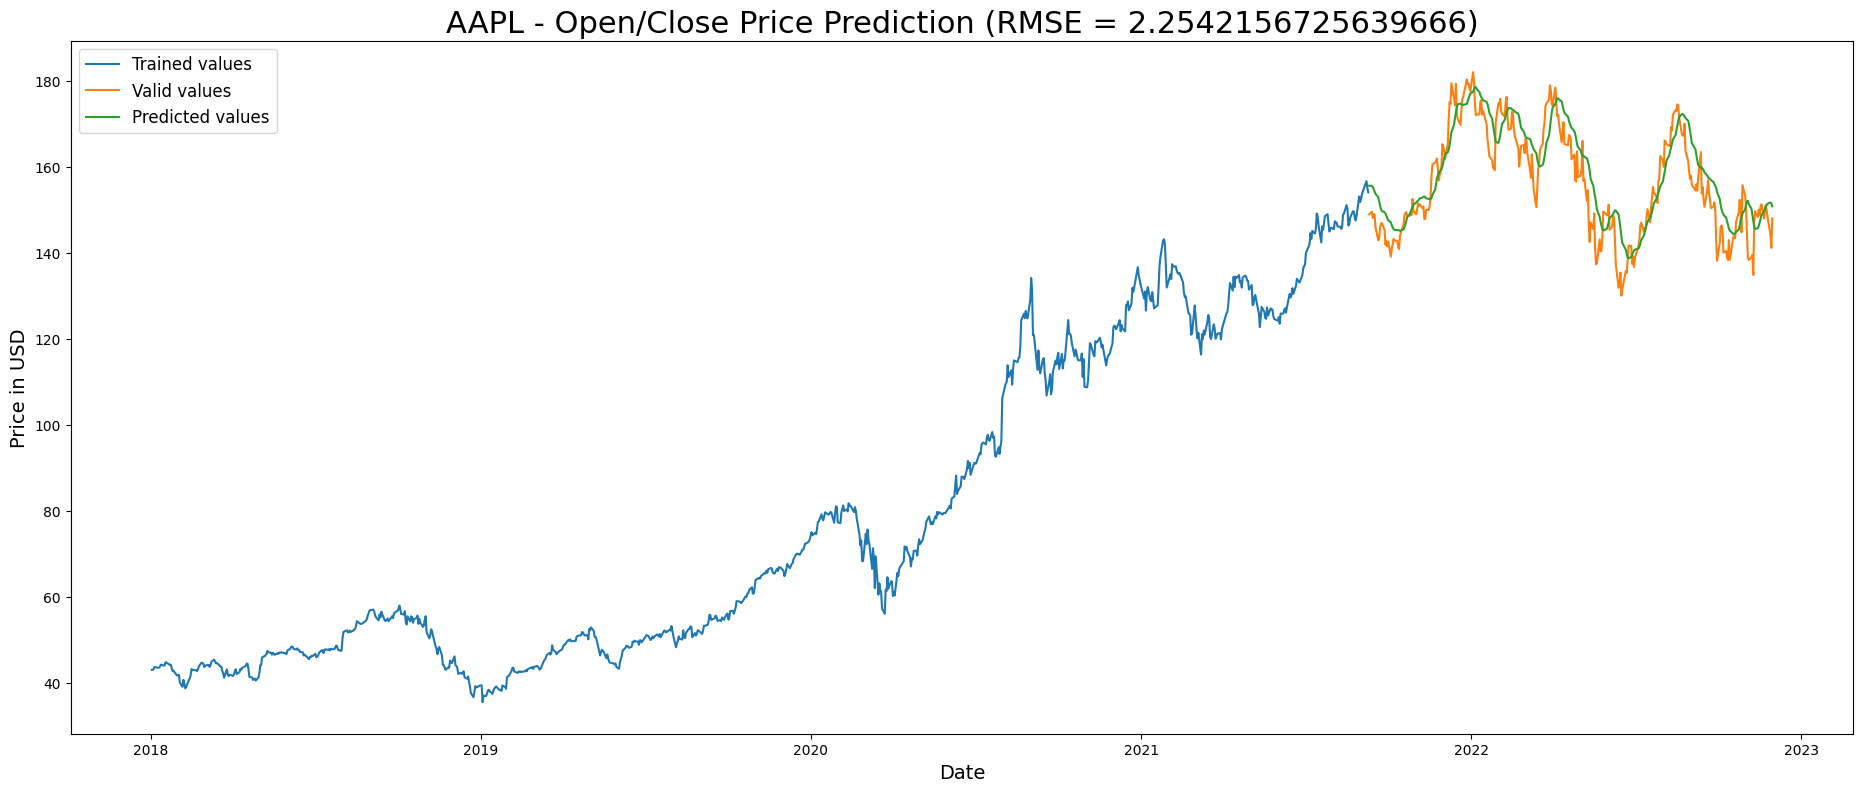

In [18]:
# Plot the data
valid = []
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predicted_closed_price

plt.figure(figsize=(23, 9))
plt.title(stock + ' - Open/Close Price Prediction (RMSE = ' + str(rmse) + ")", fontsize=22)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.legend(['Trained values', 'Valid values', 'Predicted values'], fontsize=12)
plt.show()